In [1]:
import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

sys.path.append("../../")

# Planning
sys.path.append("../Planning/")
import Planners as Planners

# Control
sys.path.append("../Acting/")
import TrajectorySamplers as TrajectorySamplers

# Model
sys.path.append("../Learning/")
import Models as Models

# Simple RL
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.tasks.navigation.NavigationWorldMDP import *
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState
from simple_rl.mdp.StateClass import State

# IRL
sys.path.append("../MLIRL")
from MLIRL import MLIRL

# MaxEnt
sys.path.append("../MaxEntIRL")
from MaxEntIRL import *

# Eval
sys.path.append("../utils/")
from Evaluation import *

import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
# style.use('classic')
%matplotlib inline

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 55

%matplotlib inline
%load_ext autoreload
%autoreload 2

Torch Version: 0.5.0a0+ab6afc2


In [2]:
import math
import networkx as nx
from networkx.drawing.nx_agraph import write_dot
import tempfile
import pydot

class IntState(State):
    ''' Class for Grid World States '''

    def __init__(self, x):
        State.__init__(self, data=x)
        self.x = round(x, 10)

    def __hash__(self):
        return hash(self.data)

    def __str__(self):
        return "s: (" + str(self.x) + ")"

    def __repr__(self):
        return self.__str__()

    def __eq__(self, other):
        return isinstance(other, IntState) and self.x == other.x
    
class MDP(object):
    
    def __init__(self, S, A, R, T, gamma=0.99):
        self.S = S
        self.A = A
        self.R = R
        self.T = T
        self.gamma = gamma

    def __nx_pydot_img(self, G):
        
        tmp_img = tempfile.mktemp()
        write_dot(G, tmp_img)
        g = pydot.graph_from_dot_file(tmp_img)[0]
        g.write_png(tmp_img)
        img = plt.imread(tmp_img)
        return img
        
    def view(self, R=None, title=""):
        
        G = nx.DiGraph()
        E = []
        G.add_nodes_from(self.S)
        if R is None:
            R_ = self.R
        else:
            R_ = R
            
        for s in self.S:
            for a in self.A:
                for sp, p in self.T(s,a):
                    if R_ is None:
                        elabel='({}): p={:.4f}'.format(a, round(p,4))
                    else:
                        elabel='({}): p={:.4f}, r={:.4f}'.format(a, round(p,4), R_(s,a))
                    G.add_edge(s, sp, color="gray", label=elabel)                    
        pos = nx.fruchterman_reingold_layout(G, iterations=100)
        img = self.__nx_pydot_img(G)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
        return G, img
    
    def view_trajectory(self, traj, title=""):

        traj_sa = defaultdict(lambda: False)
        for (s,a) in traj:
            traj_sa[(s,a)] = True
            
        G = nx.DiGraph()
        E = []
        G.add_nodes_from(self.S)
        for si, s in enumerate(self.S):
            for ai, a in enumerate(self.A):
                for sp, p in self.T(s,a):
                    G.add_edge(s, sp, color="red" if traj_sa[(s,a)] else "gray")
        pos = nx.fruchterman_reingold_layout(G, iterations=100)
        img = self.__nx_pydot_img(G)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
        return G, img
    
    def view_policy(self, policy, title=""):
        
        G = nx.DiGraph()
        E = []
        G.add_nodes_from(self.S)
        for si, s in enumerate(self.S):
            for ai, a in enumerate(self.A):
                for sp, p in self.T(s,a):
                    elabel='({}): Pi={:.4f}'.format(a, round(policy(si,ai),4))
                    G.add_edge(s, sp, color="gray", label=elabel)                    
        pos = nx.fruchterman_reingold_layout(G, iterations=100)
        img = self.__nx_pydot_img(G)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)
        return G, img

## SVF

In [3]:
# TEST: I/P: trajectory that toggles beween two states. O/P: SVF should approximate uniform distribution.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1)]
trajectory_list = [[(S[np.random.randint(0, len(S))],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0.5,0.5]) < 0.01

In [4]:
# TEST: I/P: trajectory that stays in one state. O/P: SVF should have all mass on that state.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1)]
trajectory_list = [[(S[0],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[1.,0]) < 1e-7

In [5]:
# TEST: I/P: trajectory that stays in another state. O/P: SVF should have all mass on that state.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1)]
trajectory_list = [[(S[1],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0,1.]) < 1e-7

In [6]:
# TEST: I/P: trajectory that toggles between 3 states. O/P: SVF should approximate uniform distribution.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1),(2,2)] #list(np.random.randint(0,2,(1000,2)))
trajectory_list = [[(S[np.random.randint(0, len(S))],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0.33,0.33,0.33]) < 0.01

In [7]:
# TEST: I/P: trajectory that toggles between 2 of the states. O/P: SVF should approximate uniform distribution 
# on those 2 states and 0 mass on unvisited state.
n_traj = 100
traj_len = 1000
S = [(0,0),(1,1),(2,2)] #list(np.random.randint(0,2,(1000,2)))
trajectory_list = [[(S[np.random.choice([0,2])],0) for j in range(traj_len)] for i in range(n_traj)]
assert np.linalg.norm(compute_svf(trajectory_list, S)-[0.5,0,0.5]) < 0.01

## Expected SVF

In [8]:
"""
TEST
I/P: 2 state MDP with Policy that stays in state 2.
O/P: Expected SVF with all mass on state 2.
"""
S = [IntState(s) for s in [1,2]] # S1, S2
A = ["stay", "move"]

T_dict = {S[0]: {"stay": S[0], "move": S[1]},
     S[1]:{"stay": S[1], "move": S[0]}}

def T(s,a): return [(T_dict[s][a], 1.)]
trajectory_list = [list(zip(np.random.choice([S[1]], 10), np.random.choice(["stay", "move"], 10))) 
                   for i in range(100)] # data doesn't matter for expected SVF, it's only used for determining N.
# Policy: stay in S2
Pi = np.array(
      [[0,1], # Pi[S1]
      [1,0]] # Pi[S2]
)
assert np.linalg.norm(compute_expected_svf(trajectory_list, S, A, Pi, T) - [0,1]) < 1e-8

In [9]:
"""
TEST
I/P: 2 state MDP with Policy that toggles between 2 states.
O/P: Expected SVF should approxiamte uniform distribution.
"""
S = [IntState(s) for s in [1,2]] # S1, S2
A = ["stay", "move"]

T_dict = {S[0]: {"stay": S[0], "move": S[1]},
     S[1]:{"stay": S[1], "move": S[0]}}
def T(s,a): return [(T_dict[s][a], 1.)]
trajectory_list = [list(zip(np.random.choice([S[0],S[1]], 10), np.random.choice(["stay", "move"], 10)))
                   for i in range(100)] # data doesn't matter for expected SVF, it's only used for determining N.
# Policy: keep jumping between S1 and S2
Pi = np.array(
      [[0,1], # Pi[S1]
      [0,1]] # Pi[S2]
)
assert np.linalg.norm(compute_expected_svf(trajectory_list, S, A, Pi, T) - [0.5,0.5]) < 1e-5

In [10]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight, mean=-1, std=0.01)

In [11]:
# MDP
S = [IntState(s) for s in [1,2,3,4]]
A = ["stay", "A1", "A2"]

T_dict = {
    S[0]: {"stay": S[0],
           "A1": S[1],
           "A2": S[2]
          },
    S[1]: {"stay": S[1],
           "A1": S[0],
           "A2": S[3]
          },
    S[2]: {"stay": S[2],
           "A1": S[0],
           "A2": S[3]
          },
    S[3]: {"stay": S[3],
           "A1": S[3],
           "A2": S[3]
          },
}
def T(s,a): return [(T_dict[s][a], 1.)]
trajectory_list = [[(S[0], "A1"), (S[1], "A2"), (S[3], "stay")],
                   [(S[0], "A2"), (S[2], "A2"), (S[3], "stay")],
                  ]
# Params
gamma = 0.99

# Features
phi_dict = {S[0]: [0,0,0,1],
            S[1]: [0,0,1,0],
            S[2]: [0,1,0,0],
            S[3]: [1,0,0,0]}
phi = lambda s: torch.FloatTensor(phi_dict[s])
phi_dim = len(phi(S[0]))

## MaxEnt IRL

In [12]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 0
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

maxent_loss_history, maxent_learned_policies, maxent_log_likelihood = MaxEntIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, gamma, 
                                                  verbose=True, debug=False, n_iters=100, boltzmann_temp=1.)

MaxEntIRL params 
-----
	 Domains: 2, sizes: [4, 4],
	 Action dim: 3, 
	 Feature dim: 4,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 100, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.99,
Running Backward Pass  [  ] Backward pass converged @ 30.
Running Backward Pass  [  ] Backward pass converged @ 30.

>>> Iter: 0000 (0.010s): loss = 00.143689, likelihood = 0.0048
Running Backward Pass  [  ] Backward pass converged @ 20.
Running Backward Pass  [  ] Backward pass converged @ 20.

>>> Iter: 0001 (0.007s): loss = 00.129016, likelihood = 0.0128
Running Backward Pass  [  ] Backward pass converged @ 16.
Running Backward Pass  [  ] Backward pass converged @ 16.

>>> Iter: 0002 (0.006s): loss = 00.115766, likelihood = 0.0233
Running Backward Pass  [  ] Backward pass converged @ 13.
Running Backward Pass  [  ] Backward pass converged @ 13.

>>> Iter: 0003 (0.005s): loss = 00.103907, likelihood = 0.0354
Running Backward Pass  [  ] Backward pass converged @ 12.
Runn

Running Backward Pass  [  ] Backward pass converged @ 4.
Running Backward Pass  [  ] Backward pass converged @ 4.

>>> Iter: 0082 (0.007s): loss = 00.004075, likelihood = 0.2379
Running Backward Pass  [  ] Backward pass converged @ 4.
Running Backward Pass  [  ] Backward pass converged @ 4.

>>> Iter: 0083 (0.005s): loss = 00.004023, likelihood = 0.2381
Running Backward Pass  [  ] Backward pass converged @ 4.
Running Backward Pass  [  ] Backward pass converged @ 4.

>>> Iter: 0084 (0.005s): loss = 00.003972, likelihood = 0.2382
Running Backward Pass  [  ] Backward pass converged @ 4.
Running Backward Pass  [  ] Backward pass converged @ 4.

>>> Iter: 0085 (0.004s): loss = 00.003922, likelihood = 0.2384
Running Backward Pass  [  ] Backward pass converged @ 4.
Running Backward Pass  [  ] Backward pass converged @ 4.

>>> Iter: 0086 (0.006s): loss = 00.003874, likelihood = 0.2385
Running Backward Pass  [  ] Backward pass converged @ 4.
Running Backward Pass  [  ] Backward pass converged @

Text(0.5,0,'Iterations')

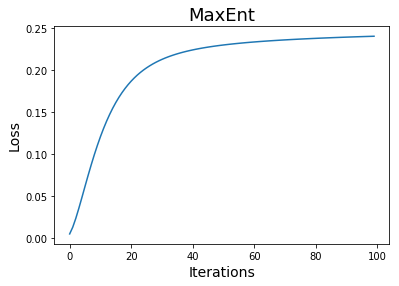

In [13]:
plt.plot(np.exp(np.array(maxent_log_likelihood)))
plt.title("MaxEnt")
plt.ylabel("Loss")
plt.xlabel("Iterations")

## Max Likelihood IRL

In [15]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 0
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

policy = lambda Q, temp=1.0: Planners.log_boltzmann_dist(Q, temp)

In [16]:
mlirl_loss_history, mlirl_learned_policies = MLIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, 
                                              policy, gamma, verbose=True, n_iters=100)

MLIRL params 
-----
	 Domains: 2, sizes: [4, 4],
	 Action dim: 3, 
	 Feature dim: 4,
	 Iterations: 100, 
	 Max likelihood: 0.99,
	 VI iterations: 100, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.99, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-1.9547, -1.6213, -1.2880, -0.9547])
Running VI [  ] VI converged @ 5.
Running VI [  ] VI converged @ 5.

>>> Iter: 0000 (0.021s): loss = 02.244349, likelihood = 0.1060
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0001 (0.015s): loss = 02.167548, likelihood = 0.1145
Running VI [  ] VI converged @ 5.
Running VI [  ] VI converged @ 5.

>>> Iter: 0002 (0.018s): loss = 02.098363, likelihood = 0.1227
Running VI [  ] VI converged @ 5.
Running VI [  ] VI converged @ 5.

>>> Iter: 0003 (0.019s): loss = 02.036423, likelihood = 0.1305
Running VI [  ] VI converged @ 6.
Running VI [  ] VI converged @ 6.

>>> Iter: 0004 (0.020s): loss = 01.980940, likelihood = 0.1379
Running VI [ 


>>> Iter: 0068 (0.015s): loss = 01.422195, likelihood = 0.2412
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0069 (0.015s): loss = 01.421568, likelihood = 0.2413
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0070 (0.015s): loss = 01.420964, likelihood = 0.2415
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0071 (0.015s): loss = 01.420378, likelihood = 0.2416
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0072 (0.015s): loss = 01.419809, likelihood = 0.2418
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0073 (0.015s): loss = 01.419259, likelihood = 0.2419
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0074 (0.015s): loss = 01.418724, likelihood = 0.2420
Running VI [  ] VI converged @ 4.
Running VI [  ] VI converged @ 4.

>>> Iter: 0075 (0.014s): loss = 01.418204, likelihood = 0.2421
Running VI [

Text(0.5,0,'Iterations')

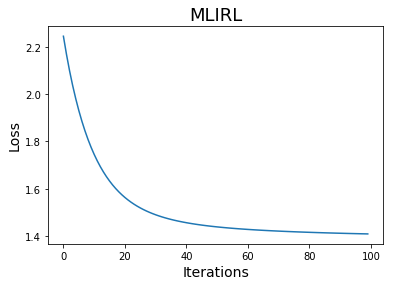

In [17]:
plt.plot(np.array(mlirl_loss_history))
plt.title("MLIRL")
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [18]:
mlirl_learned_policies[-1].data.numpy().round(2)

array([[0.  , 0.5 , 0.5 ],
       [0.01, 0.  , 0.99],
       [0.01, 0.  , 0.99],
       [0.33, 0.33, 0.33]], dtype=float32)

## MDP

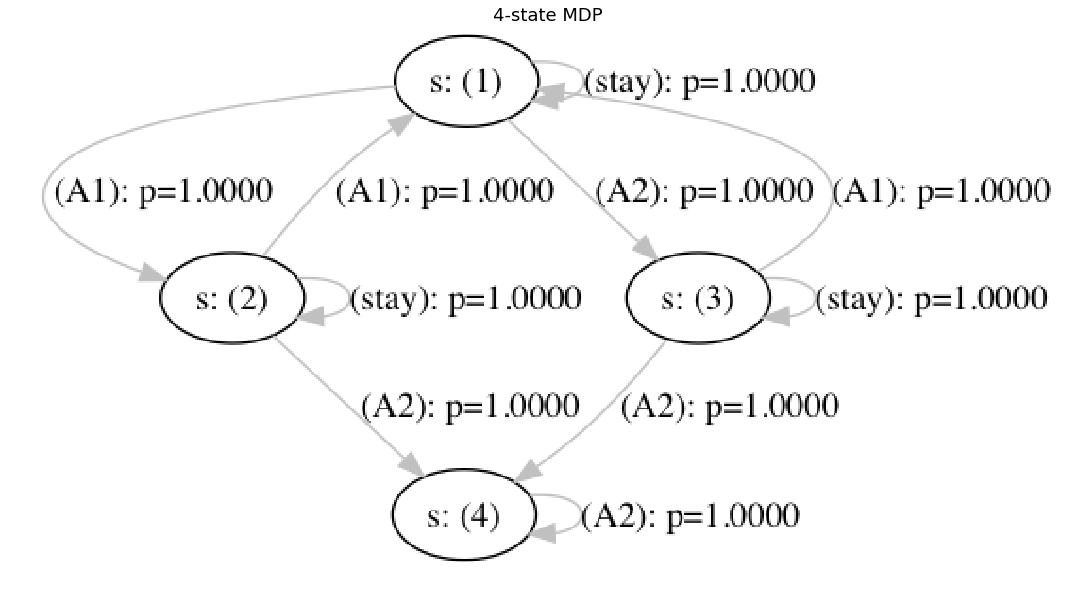

In [19]:
mdp = MDP(S, A, None, T)
plt.figure(figsize=(20,10))
G, _ = mdp.view(title="4-state MDP")

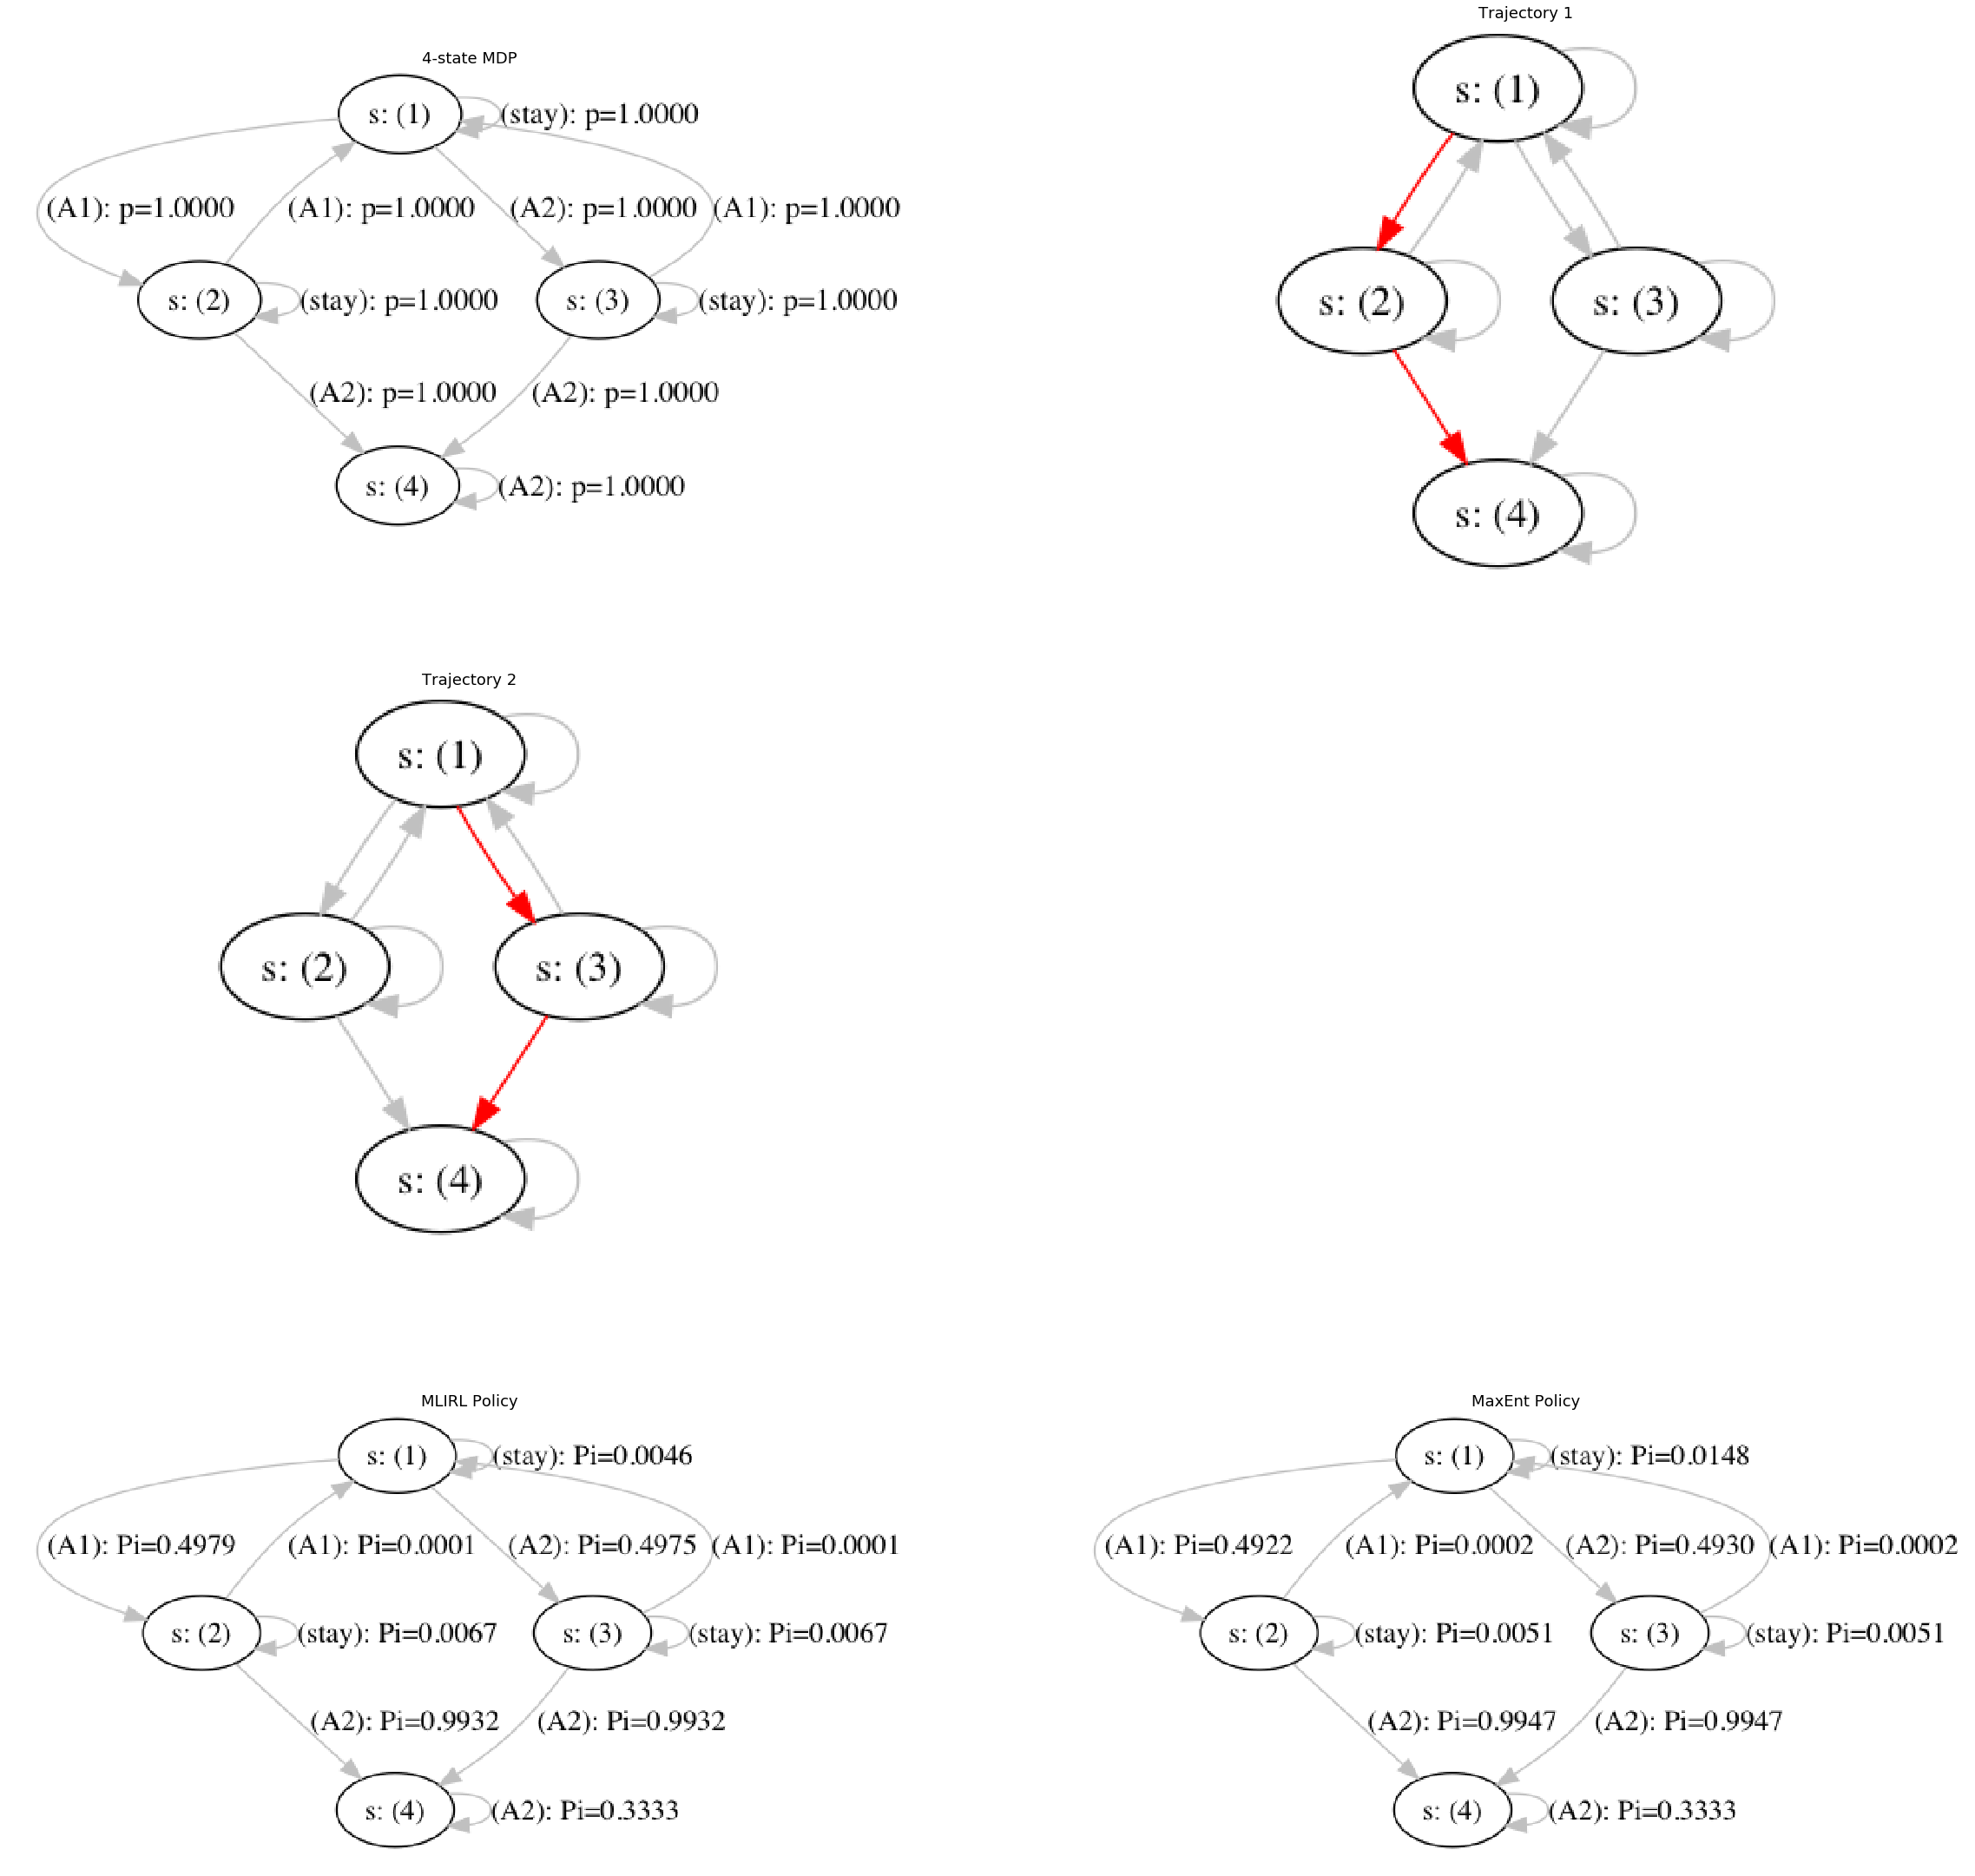

In [24]:
plt.figure(figsize=(40,40))
plt.subplot(321)
_ = mdp.view(title="4-state MDP")
plt.subplot(322)
_ = mdp.view_trajectory(trajectory_list[0], title="Trajectory 1")
plt.subplot(323)
_ = mdp.view_trajectory(trajectory_list[1], title="Trajectory 2")
plt.subplot(325)
_ = mdp.view_policy(lambda s_idx, a_idx: mlirl_learned_policies[-1].data.numpy()[s_idx, a_idx], title="MLIRL Policy")
plt.subplot(326)
_ = mdp.view_policy(lambda s_idx, a_idx: maxent_learned_policies[-1][s_idx, a_idx], title="MaxEnt Policy")

Text(0.5,0,'Iterations')

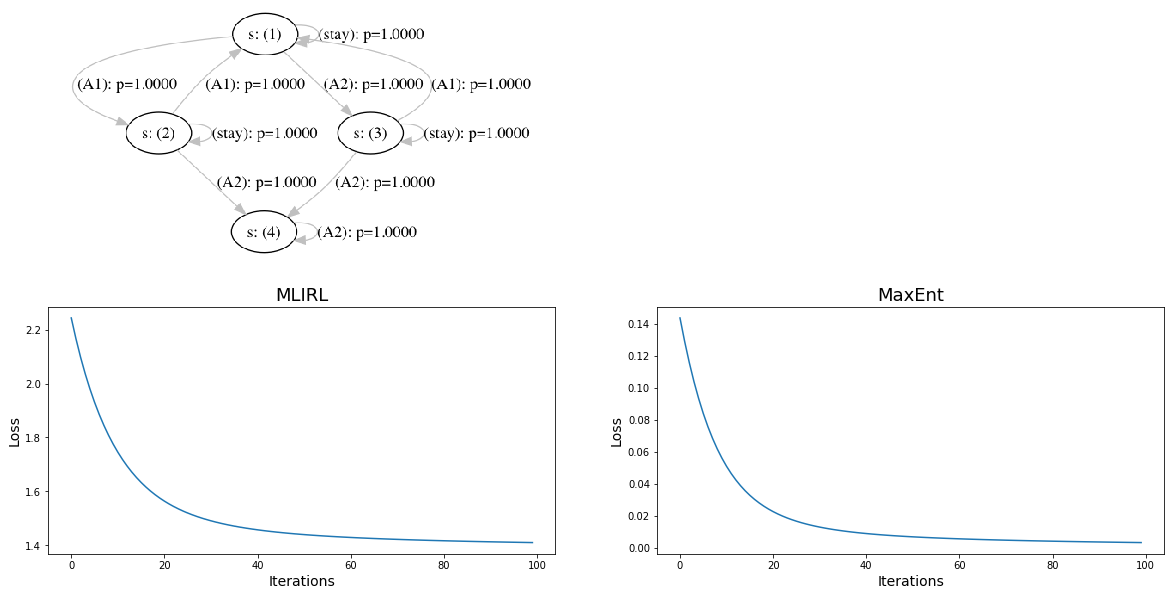

In [27]:
plt.figure(figsize=(20,10))

plt.subplot(221)
_ = mdp.view()
plt.subplot(223)
plt.plot(np.array(mlirl_loss_history))
plt.title("MLIRL")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.subplot(224)
plt.plot(np.array(maxent_loss_history))
plt.title("MaxEnt")
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [28]:
# Features
phi_dict = {S[0]: [0,0,0,1],
            S[1]: [0,0,1,0],
            S[2]: [0,1,0,0],
            S[3]: [1,0,0,0]}
phi = lambda s: torch.FloatTensor(phi_dict[s])
phi_dim = len(phi(S[0]))

trajectory_list = [[(S[0], "A1"), (S[1], "A2"), (S[3], "stay")],
                  ]

Text(0.5,0,'Iterations')

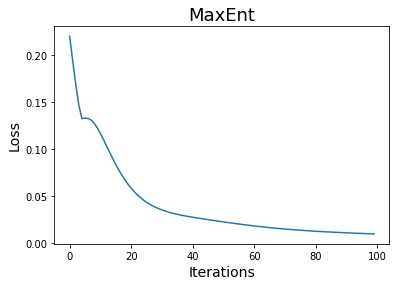

In [30]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 0
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

maxent_loss_history, learned_policies, maxent_log_likelihood = MaxEntIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, gamma, 
                                                  verbose=False, debug=False, n_iters=100, boltzmann_temp=1.)
plt.plot(np.array(maxent_loss_history))
plt.title("MaxEnt")
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [31]:
[R_model(phi(s)) for s in S]

[tensor([-4.3270], grad_fn=<AddBackward0>),
 tensor([-3.1180], grad_fn=<AddBackward0>),
 tensor([-6.5420], grad_fn=<AddBackward0>),
 tensor([0.], grad_fn=<AddBackward0>)]

Text(0.5,0,'Iterations')

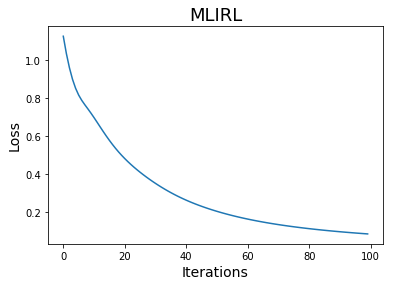

In [32]:
R_model = Models.LinearRewardModel_ReLU(phi_dim, 0)
R_model.apply(weights_init)

# Optimizer
lr, weight_decay = 0.1, 0
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)

policy = lambda Q, temp=1.0: Planners.log_boltzmann_dist(Q, temp)

mlirl_loss_history, mlirl_learned_policies = MLIRL(trajectory_list, lambda _: S, lambda _: T, A, phi, R_model, R_optimizer, 
                                              policy, gamma, verbose=False, n_iters=100)

plt.plot(np.array(mlirl_loss_history))
plt.title("MLIRL")
plt.ylabel("Loss")
plt.xlabel("Iterations")

In [33]:
[R_model(phi(s)) for s in S]

[tensor([-5.0769], grad_fn=<AddBackward0>),
 tensor([-3.0301], grad_fn=<AddBackward0>),
 tensor([-6.5548], grad_fn=<AddBackward0>),
 tensor([-0.9900], grad_fn=<AddBackward0>)]

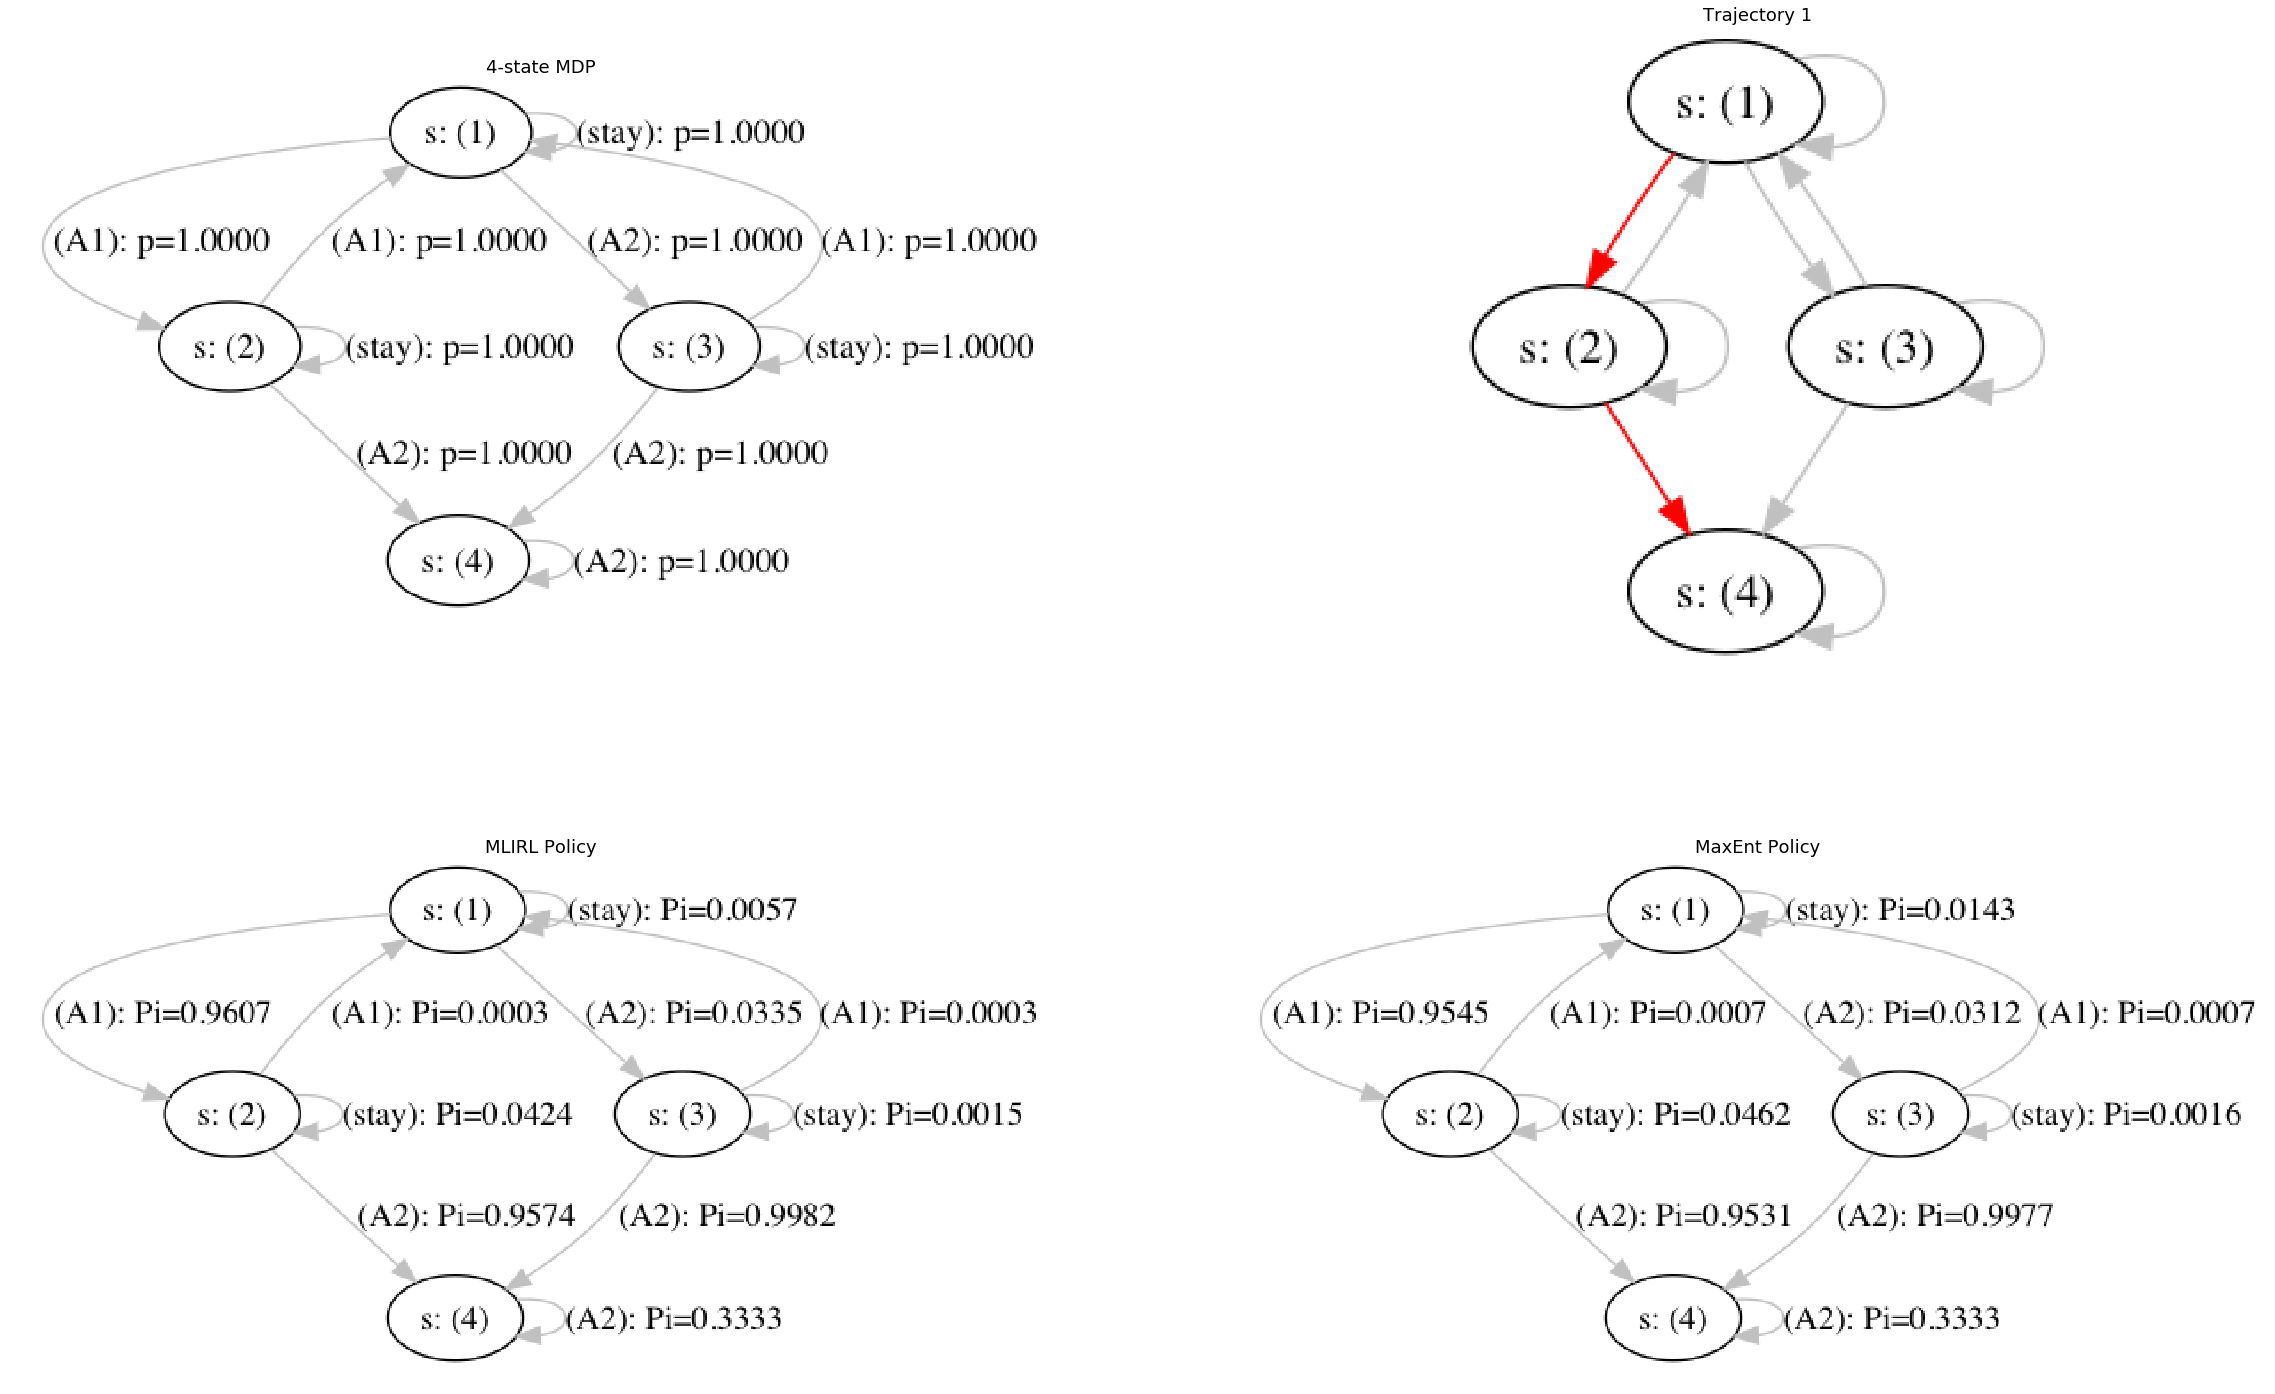

In [34]:
plt.figure(figsize=(40,40))
plt.subplot(321)
_ = mdp.view(title="4-state MDP")
plt.subplot(322)
_ = mdp.view_trajectory(trajectory_list[0], title="Trajectory 1")
# plt.subplot(323)
# _ = mdp.view_trajectory(trajectory_list[1], title="Trajectory 2")
plt.subplot(323)
_ = mdp.view_policy(lambda s_idx, a_idx: mlirl_learned_policies[-1].data.numpy()[s_idx, a_idx], title="MLIRL Policy")
plt.subplot(324)
_ = mdp.view_policy(lambda s_idx, a_idx: learned_policies[-1][s_idx, a_idx], title="MaxEnt Policy")